## Executive Summary (TL;DR)

Delivery delays only meaningfully hurt customer satisfaction after a ~3-day threshold.
Most SLA violations occur during carrier transit rather than seller handling, making downstream logistics the dominant risk factor.
Geographic analysis reveals that regions like Rio de Janeiro combine high order volume with elevated delays, representing the highest operational priority for intervention.

---

# Step 1: Project Overview

**E-commerce Logistics: Delivery Performance and Customer Satisfaction**


## 1.1 Problem Framing

In large online marketplaces, logistics performance is a critical determinant of customer experience, operational cost, and seller reputation. While pricing and product variety attract customers, on-time delivery is often the strongest driver of satisfaction and repeat purchases.

Olist operates as a marketplace connecting customers, sellers, and logistics partners across Brazil. This distributed structure introduces complexity:

* Orders may involve multiple sellers
* Shipping distances vary widely across regions
* Delivery depends on coordination between sellers and carriers

Late deliveries can result from a range of factors, including seller handling time, shipping distance, regional infrastructure, and carrier performance. However, without a systematic analysis, it is difficult for the business to identify which factors most strongly contribute to delays and how those delays affect customer satisfaction.

This project aims to analyze historical order and delivery data to identify the primary drivers of late deliveries and quantify their relationship with customer review scores.

---

## 1.2 Business Relevance

For a stakeholder such as the Head of Logistics, this analysis provides actionable insights to support both strategic and operational decisions:

* **Operational optimization:** Identify bottlenecks in the delivery pipeline (e.g., seller preparation time vs. transit time).
* **Regional strategy:** Understand whether certain geographic regions consistently underperform and may require alternative logistics partners or service-level adjustments.
* **Customer experience management:** Quantify how delivery delays impact customer ratings, enabling better prioritization of logistics improvements.
* **Performance monitoring:** Establish data-driven benchmarks for on-time delivery and delay tolerance.

By linking logistics performance directly to customer satisfaction metrics, this analysis helps translate operational data into business impact.

---

## 1.3 Key Analytical Questions

This project is structured around the following core questions:

1. **What are the primary drivers of late deliveries?**

   * How do factors such as shipping distance, seller handling time, and carrier transit time contribute to delivery delays?

2. **Are delivery delays geographically concentrated?**

   * Do certain states or regions experience systematically higher delay rates compared to others?

3. **How does the magnitude of delivery delay impact customer satisfaction?**
   * Specifically, is there a threshold effect where small delays (e.g., 1–2 days) are tolerated by customers, but larger delays (e.g., 5+ days) result in a disproportionate drop in review scores?

---

**Scope Note:**
This analysis focuses on observed historical data and identifies correlations rather than causal effects. External factors not captured in the dataset (e.g., weather events or carrier-specific disruptions) are outside the scope of this project.

---

# Step 2: Dataset Description

### 2.1 Data Sources

This project primarily uses the **Brazilian E-commerce Public Dataset by Olist**, available on Kaggle:

* **Olist Dataset:** https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

The dataset contains approximately **100,000 orders** placed between **2016 and 2018**, distributed across multiple relational tables representing customers, orders, sellers, products, reviews, and geolocation data.

To support geographic visualization and state-level analysis, an additional public dataset is used:

* **Brazil States GeoJSON:** https://www.kaggle.com/datasets/thiagobodruk/brazil-geojson

This GeoJSON file provides polygon boundaries for Brazilian states and is used exclusively for visualization purposes in the geographic EDA section. It does not introduce new analytical variables or affect delivery delay calculations.

---

### 2.2 Tables Used in This Analysis

Although the full Olist dataset includes 8+ tables, this analysis focuses only on the subset required to answer the logistics performance and customer satisfaction questions.

The following tables are used:

* **`olist_orders_dataset`**  
  Core order-level information, including order status and key timestamps.

* **`olist_order_items_dataset`**  
  Line-item–level data linking orders to products and sellers.

* **`olist_sellers_dataset`**  
  Seller location data, used for geographic and distance-related analysis.

* **`olist_customers_dataset`**  
  Customer location data, used for geographic and distance-related analysis.

* **`olist_order_reviews_dataset`**  
  Customer review scores and review timestamps.

* **`olist_geolocation_dataset`**  
  Geographic reference data used to map ZIP code prefixes to latitude and longitude.

Other tables (e.g., payments) are excluded, as they are not directly relevant to delivery timing, SLA performance, or customer satisfaction in this project.


### 2.3 Key Variables of Interest

The analysis relies on the following critical variables:

**Order & Delivery Timing**

* `order_purchase_timestamp`
* `order_delivered_customer_date`
* `order_estimated_delivery_date`
* `order_status`

**Customer Satisfaction**

* `review_score`
* `review_creation_date`

**Logistics & Geography**

* `seller_zip_code_prefix`
* `customer_zip_code_prefix`
* Geolocation latitude and longitude (derived from ZIP code prefixes)

These variables enable the computation of delivery delays, on-time performance, geographic patterns, and their relationship to customer ratings.

---

### 2.4 Known Data Limitations

* The dataset is anonymized, and no personally identifiable customer or seller information is available.
* The data covers a fixed historical period (2016–2018) and may not reflect current logistics performance.
* Carrier-level identifiers are not available, limiting analysis of individual logistics providers.
* External factors such as weather events, strikes, or regional infrastructure disruptions are not captured.

---

# Step 3: Assumptions & Scope

### 3.1 In Scope

This analysis focuses on:

* Orders with status = delivered
* Orders with valid and non-null delivery and estimate timestamps
* Historical analysis of delivery performance and customer review outcomes
* Descriptive and inferential analysis of correlations, not causal inference

---

### 3.2 Out of Scope

The following are explicitly excluded from this project:

* Predictive modeling (e.g., forecasting delivery times or sales)
* Analysis of canceled or unavailable orders, except where necessary for data filtering
* Financial performance analysis beyond basic freight or price context
* Carrier-level performance comparisons (carrier identifiers are not available)
* External data integration (e.g., weather, holidays, traffic)

---

### 3.3 Initial Assumptions

The analysis proceeds under the following assumptions:

* All monetary values (`price`, `freight_value`) are denominated in Brazilian Reais (BRL).
* Timestamp fields are assumed to be recorded consistently and accurately.
* `order_estimated_delivery_date` represents the promised delivery expectation communicated to customers.
* Customer review scores are assumed to reflect the overall order experience, with delivery performance being a significant contributing factor.

---

# Step 4: Data Quality Audit

### 4.1 Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopy.distance import geodesic


pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.3f}".format)

### 4.2 Data Loading

In [2]:
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
sellers = pd.read_csv("data/olist_sellers_dataset.csv")
customers = pd.read_csv("data/olist_customers_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
brazil_states = gpd.read_file("data/brazil_geo.json")

# Basic shape check
dataset = {
    "orders": orders,
    "order_items": order_items,
    "sellers": sellers,
    "reviews": reviews,
    "geolocation": geolocation,
    "customers": customers,
    "states": brazil_states
}

for name, df in dataset.items():
    print(f"{name}: {df.shape}")


orders: (99441, 8)
order_items: (112650, 7)
sellers: (3095, 4)
reviews: (99224, 7)
geolocation: (1000163, 5)
customers: (99441, 5)
states: (27, 3)


In [3]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.900,13.290
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.900,19.930
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.000,17.870
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.990,12.790
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.900,18.140


In [5]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [6]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [7]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.546,-46.639,sao paulo,SP
1,1046,-23.546,-46.645,sao paulo,SP
2,1046,-23.546,-46.643,sao paulo,SP
3,1041,-23.544,-46.639,sao paulo,SP
4,1035,-23.542,-46.642,sao paulo,SP


In [8]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [9]:
brazil_states.head()

,id,name,geometry
0,AC,Acre,"POLYGON ((-73.33251 -7.32488, -73.27482 -7.350..."
1,AL,Alagoas,"MULTIPOLYGON (((-35.90153 -9.8618, -35.90153 -..."
2,AP,Amapá,"MULTIPOLYGON (((-50.02403 0.85986, -50.02403 0..."
3,AM,Amazonas,"MULTIPOLYGON (((-53.62548 -26.88481, -53.619 -..."
4,BA,Bahia,"MULTIPOLYGON (((-38.69708 -17.97903, -38.69708..."


### 4.3 Missing Value Profiling

In [10]:
# Focus on delivered orders
delivered_orders = orders[orders["order_status"] == "delivered"]

missing_summary = (
    delivered_orders.isna()
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

missing_summary

order_approved_at               0.015
order_delivered_customer_date   0.008
order_delivered_carrier_date    0.002
order_id                        0.000
customer_id                     0.000
order_status                    0.000
order_purchase_timestamp        0.000
order_estimated_delivery_date   0.000
dtype: float64

**Observation:**
Approximately **0.8% of orders marked as `delivered` are missing `order_delivered_customer_date`**.

**Impact:**
Delivery delay cannot be calculated for these orders, making them unusable for logistics performance analysis.

**Action Required:**
Exclude delivered orders with missing delivery timestamps from delay-based metrics.

---

### 4.4 Data Date-Time Integrity Checks

In [11]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [12]:
date_columns = [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

# Convert to datetime
for col in date_columns:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")

orders[date_columns].dtypes

order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

**Observation:**
All timestamp columns are initially loaded as strings and require explicit conversion to `datetime`.

**Impact:**
Without conversion, time-based calculations (e.g., delivery delay in days) would be incorrect or impossible.

**Action Required:**
Convert all relevant timestamp columns using `pd.to_datetime` with coercion.

---

### 4.5 Logical Consistency Checks

#### 4.5.1 Impossible Delivery Dates

In [13]:
invalid_delivery_dates = orders[
    (orders["order_status"] == "delivered") &
    (orders["order_delivered_customer_date"] < orders["order_purchase_timestamp"])
]

len(invalid_delivery_dates)

0

**Observation:**
After validating all delivered orders, no cases were found where `order_delivered_customer_date` occurs earlier than `order_purchase_timestamp`.

**Impact:**
This indicates that, for delivered orders with valid timestamps, the dataset is internally consistent with respect to basic delivery chronology.

**Action Required:**
No filtering is required for this condition. The data can be safely used for delivery delay calculations once missing timestamps are handled.

---

#### 4.5.2 Duplicate Order IDs

In [14]:
orders["order_id"].duplicated().sum()

0

In [15]:
order_items["order_id"].duplicated().sum()

13984

**Observation:**

* `order_id` is unique in the `orders` table.
* `order_id` appears multiple times in `order_items`, as expected due to one-to-many relationships.

**Impact:**
No integrity issues detected at the order level.

**Action Required:**
No action required; behavior is consistent with relational design.

---

### 4.6 Review Score Distribution Check

In [16]:
reviews["review_score"].describe()

count   99224.000
mean        4.086
std         1.348
min         1.000
25%         4.000
50%         5.000
75%         5.000
max         5.000
Name: review_score, dtype: float64

**Observation:**
All `review_score` values fall within the expected range of **1 to 5**, with no outliers or invalid entries.

**Impact:**
Review scores are safe to use directly in customer satisfaction analysis.

**Action Required:**
No cleaning required for review score values.

# Step 5: Data Cleaning Decisions

This section documents the intentional and justified transformations applied to the raw data prior to analysis.
The goal is not to “clean as much as possible,” but to ensure that derived metrics accurately reflect the underlying business processes while minimizing bias and information loss.

### 5.1 Work on Delivered Orders Only

In [17]:
orders_clean = orders[orders["order_status"] == "delivered"].copy()
orders_clean.shape

(96478, 8)

### 5.2 Handling Missing Delivery Dates

**Decision:**
Filter out the small subset (~0.8%) of orders marked as `delivered` that are missing `order_delivered_customer_date`.

**Justification:**
These records represent incomplete process logging, where the final delivery event was not captured. Because delivery timestamps are required to compute delay-based metrics, retaining these rows would introduce undefined or misleading values.

**Tradeoff:**

* **Cost:** A negligible reduction in sample size.
* **Benefit:** Guarantees 100% validity for delivery delay calculations and avoids speculative imputation.

In [18]:
initial_count = orders_clean.shape[0]

orders_clean = orders_clean.dropna(
    subset=["order_delivered_customer_date"]
)

final_count = orders_clean.shape[0]

print(f"Dropped {((initial_count - final_count)/ initial_count)*100:.2%} of delivered orders due to missing delivery timestamps.")
print(orders_clean.shape)

Dropped 0.83% of delivered orders due to missing delivery timestamps.
(96470, 8)


### 5.3 Delivery Time Metrics

**Decision:**
Convert all relevant timestamp fields to `datetime` and derive two duration-based features:

* `actual_wait_time`: time elapsed from order purchase to customer delivery
* `delivery_delay`: difference between actual delivery date and estimated delivery date

**Justification:**
Raw timestamps are not directly interpretable for behavioral or operational analysis. Duration-based features enable meaningful aggregation, comparison, and correlation with customer satisfaction.

**Tradeoff:**

* Increases feature complexity slightly
* Significantly improves interpretability and analytical power

In [19]:
# Convert Timestamps to Datetime
date_columns = [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

for col in date_columns:
    orders_clean[col] = pd.to_datetime(orders_clean[col], errors="coerce")

orders_clean[date_columns].dtypes

order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [20]:
# Feature Engineering: Delivery metrics 
orders_clean["actual_wait_time"] = (
    orders_clean["order_delivered_customer_date"] -
    orders_clean["order_purchase_timestamp"]
).dt.days

orders_clean["delivery_delay"] = (
    orders_clean["order_delivered_customer_date"] -
    orders_clean["order_estimated_delivery_date"]
).dt.days

orders_clean[["actual_wait_time", "delivery_delay"]].describe()

,actual_wait_time,delivery_delay
count,96470.000,96470.000
mean,12.094,-11.876
std,9.551,10.182
min,0.000,-147.000
25%,6.000,-17.000
50%,10.000,-12.000
75%,15.000,-7.000
max,209.000,188.000


### 5.4 Aggregation Strategy for Multi-Item

**Decision:**
Aggregate `order_items` data to the `order_id` level using the maximum `shipping_limit_date` as the representative seller handling deadline for the order.

**Justification:**
Customer satisfaction and delivery outcomes are measured at the order level, not the item level. For orders involving multiple sellers, the overall delivery cannot occur until all items have been handed off to logistics providers. Therefore, the seller with the *latest* shipping deadline acts as the bottleneck for the order.

Using the maximum `shipping_limit_date`:

* Reflects real-world fulfillment constraints
* Aligns with customer perception (“my order is late” regardless of which seller caused it)
* Avoids understating seller handling time

**Tradeoff:**

* May over-attribute delay responsibility to sellers in mixed-performance orders
* However, alternative strategies (mean or minimum) would systematically underestimate true order-level handling time

In [21]:
# Convert Shipping Limit Date
order_items["shipping_limit_date"] = pd.to_datetime(
    order_items["shipping_limit_date"],
    errors="coerce"
)

In [22]:
# Aggregate to Order Level (Bottleneck Strategy)
order_items_agg = (
    order_items
    .groupby("order_id")
    .agg(
        latest_shipping_limit_date=("shipping_limit_date", "max"),
        num_items=("order_item_id", "count"),
        num_sellers=("seller_id", "nunique")
    )
    .reset_index()
)

order_items_agg.head()

,order_id,latest_shipping_limit_date,num_items,num_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-19 09:45:35,1,1
1,00018f77f2f0320c557190d7a144bdd3,2017-05-03 11:05:13,1,1
2,000229ec398224ef6ca0657da4fc703e,2018-01-18 14:48:30,1,1
3,00024acbcdf0a6daa1e931b038114c75,2018-08-15 10:10:18,1,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-13 13:57:51,1,1


In [23]:
# Merge Order-Level Tables
orders_enriched = (
    orders_clean
    .merge(order_items_agg, on="order_id", how="left")
    .merge(reviews[["order_id", "review_score"]], on="order_id", how="left")
)
orders_enriched.shape

(96999, 14)

In [24]:
orders_enriched.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,actual_wait_time,delivery_delay,latest_shipping_limit_date,num_items,num_sellers,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8,-8,2017-10-06 11:07:15,1,1,4.000
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13,-6,2018-07-30 03:24:27,1,1,4.000
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9,-18,2018-08-13 08:55:23,1,1,5.000
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13,-13,2017-11-23 19:45:59,1,1,5.000
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2,-10,2018-02-19 20:31:37,1,1,5.000


### 5.5 Geolocation Deduplication

**Decision:**
Aggregate the geolocation table by `zip_code_prefix`, using the mean latitude and longitude for each prefix.

**Justification:**
The geolocation dataset contains multiple coordinate records per ZIP code prefix. A 1:1 mapping is required to reliably join geographic data to orders and customers.

**Tradeoff:**

* Slight loss of spatial precision
* Enables consistent national-level geographic analysis appropriate to dataset granularity

In [25]:
geo_agg = (
    geolocation
    .groupby("geolocation_zip_code_prefix")
    .agg(
        lat=("geolocation_lat", "mean"),
        lng=("geolocation_lng", "mean")
    )
    .reset_index()
)
geo_agg.head()

,geolocation_zip_code_prefix,lat,lng
0,1001,-23.550,-46.634
1,1002,-23.548,-46.635
2,1003,-23.549,-46.636
3,1004,-23.550,-46.635
4,1005,-23.549,-46.637


### 5.6 Customer Geography Resolution

**Decision:**
Resolve customer location by joining the `orders` table to `olist_customers_dataset` using `customer_id`, then mapping `customer_zip_code_prefix` to latitude and longitude via the geolocation table.

**Justification:**
Customer geographic attributes do not exist in the orders table and must be sourced from the dedicated customers dataset. This preserves correct entity ownership and ensures that geographic features are derived from the appropriate relational path.

**Tradeoff:**

* Adds an additional join step
* Ensures relational correctness and prevents attribute leakage across entities

In [26]:
# Merge Customers Into Orders
orders_enriched = orders_enriched.merge(
    customers[[
        "customer_id",
        "customer_zip_code_prefix",
        "customer_city",
        "customer_state"
    ]],
    on="customer_id",
    how="left"
)

orders_enriched.shape

(96999, 17)

In [27]:
# Enrich orders with customer latitude and longitude
orders_enriched = (
    orders_enriched
    .merge(
        geo_agg,
        left_on="customer_zip_code_prefix",
        right_on="geolocation_zip_code_prefix",
        how="left"
    )
    .rename(columns={"lat": "customer_lat", "lng": "customer_lng"})
    .drop(columns=["geolocation_zip_code_prefix"])
)
orders_enriched.shape

(96999, 19)

### 5.7 Seller Geography Aggregation for Multi-Seller Orders

**Decision:**
Derive a representative seller location per order by aggregating seller ZIP codes from `order_items`, selecting the mode (most frequent) seller ZIP code for each order, and mapping it to geolocation coordinates.

**Justification:**
An order may involve multiple sellers, but geographic analysis requires a single seller reference point at the order level. Using the modal seller ZIP code provides a stable and interpretable approximation while avoiding arbitrary selection.

**Tradeoff:**

* Seller location is approximated for multi-seller orders
* Enables order-level geographic analysis consistent with customer-level outcomes

In [28]:
# Merge sellers into order item, aggregate into order level, and then merge to orders 
seller_zip_per_order = (
    order_items
    .merge(
        sellers[["seller_id", "seller_zip_code_prefix"]],
        on="seller_id",
        how="left"
    )
    .groupby("order_id")
    .agg(
        seller_zip_code_prefix=("seller_zip_code_prefix", lambda x: x.mode().iloc[0])
    )
    .reset_index()
)

orders_enriched = orders_enriched.merge(seller_zip_per_order, on="order_id", how="left")
    
orders_enriched.shape

(96999, 20)

In [29]:
# Enrich orders with seller latitude and longitude
orders_enriched = (
    orders_enriched
    .merge(
        geo_agg,
        left_on="seller_zip_code_prefix",
        right_on="geolocation_zip_code_prefix",
        how="left"
    )
    .rename(columns={
        "lat": "seller_lat",
        "lng": "seller_lng"
    })
    .drop(columns=["geolocation_zip_code_prefix"])
)
orders_enriched.shape

(96999, 22)

### 5.8 Handling Early Deliveries (Negative Delivery Delay)

**Decision:**
Retain negative `delivery_delay` values in the dataset, but cap them at `0` when constructing delay-threshold buckets for customer impact analysis.

**Justification:**
Early deliveries represent positive operational performance and should not be discarded. However, for threshold-based analysis of *delay penalties*, customers are unlikely to distinguish between “on time” and “early” delivery in a linear fashion. Treating early deliveries as `0` delay preserves interpretability while avoiding distortion of threshold effects.

**Tradeoff:**

* Raw negative values are preserved for exploratory analysis
* Threshold-based models focus on customer-perceived delay rather than operational overperformance

In [30]:
orders_enriched["delivery_delay_capped"] = (
    orders_enriched["delivery_delay"]
    .clip(lower=0)
)
orders_enriched[["delivery_delay", "delivery_delay_capped"]].describe()

,delivery_delay,delivery_delay_capped
count,96999.000,96999.000
mean,-11.880,0.719
std,10.182,4.647
min,-147.000,0.000
25%,-17.000,0.000
50%,-12.000,0.000
75%,-7.000,0.000
max,188.000,188.000


### 5.9 Final Sanity Checks

In [31]:
assert orders_enriched["order_id"].isna().sum() == 0
assert orders_enriched["actual_wait_time"].min() >= 0

orders_enriched.shape

(96999, 23)

In [32]:
orders_enriched.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,actual_wait_time,delivery_delay,latest_shipping_limit_date,num_items,num_sellers,review_score,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_lat,seller_lng,delivery_delay_capped
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8,-8,2017-10-06 11:07:15,1,1,4.000,3149,sao paulo,SP,-23.577,-46.587,9350,-23.681,-46.444,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13,-6,2018-07-30 03:24:27,1,1,4.000,47813,barreiras,BA,-12.178,-44.661,31570,-19.808,-43.980,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9,-18,2018-08-13 08:55:23,1,1,5.000,75265,vianopolis,GO,-16.745,-48.515,14840,-21.364,-48.230,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13,-13,2017-11-23 19:45:59,1,1,5.000,59296,sao goncalo do amarante,RN,-5.774,-35.271,31842,-19.838,-43.924,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2,-10,2018-02-19 20:31:37,1,1,5.000,9195,santo andre,SP,-23.676,-46.515,8752,-23.543,-46.262,0


# Step 6: Exploratory Data Analysis (EDA)

With a cleaned and relationally consistent dataset, we now transition from data preparation to investigation.
The objective of this Exploratory Data Analysis (EDA) is not to exhaustively visualize every variable, but to systematically test hypotheses derived from the business problem of delivery performance and customer satisfaction.

Where relevant, delivery delays are analyzed relative to expected operational deadlines, rather than raw durations, allowing for fair attribution of delay responsibility.

The analysis follows a structured progression:

> **Univariate → Bivariate → Multivariate**

This ensures that observed relationships are interpreted in the context of underlying distributions, operational processes, and logistical constraints.

## 6.1 Univariate Analysis: Understanding the Baseline

The purpose of this section is to understand the individual behavior and distribution of key variables before analyzing relationships between them.

### 6.1.1 Customer Satisfaction Distribution

* **Plot:** Bar chart of `review_score` (1–5)
* **Goal:**

  * Assess whether customer reviews are skewed toward high ratings
  * Understand how common low satisfaction scores are
* **Expectation:**
  Review scores are expected to be right-skewed, with a concentration at 4–5, consistent with typical e-commerce review behavior.

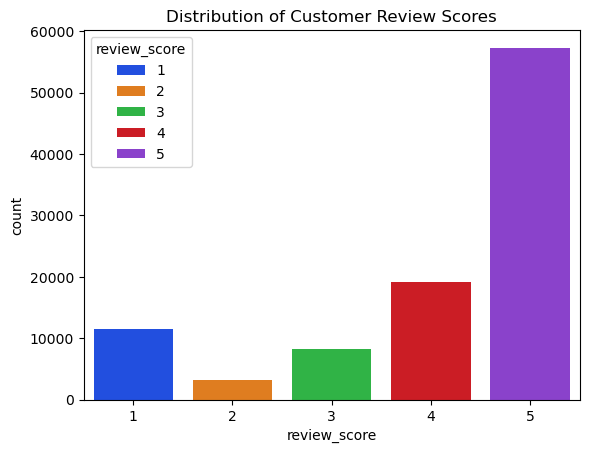

In [33]:
sns.countplot(data=reviews, x="review_score", hue="review_score", palette='bright')
plt.title("Distribution of Customer Review Scores")
plt.show()

**Interpretation**

Customer reviews are heavily concentrated at 4–5 stars, indicating generally high satisfaction. Low scores are less frequent but meaningful, justifying focused analysis on the operational factors driving these negative experiences.

---

### 6.1.2 SLA Performance Overview


* **Plot:** bar chart showing the percentage of orders:

  * Delivered early
  * Delivered on time
  * Delivered late
* **Goal:**

  * Quantify overall service-level performance
  * Establish a baseline SLA compliance rate
* **Expectation:**
  Most orders are expected to meet or exceed estimated delivery dates, with a smaller but non-negligible late-delivery segment.

In [34]:
sla_summary = (
    orders_enriched["delivery_delay"]
    .apply(lambda x: "Late" if x > 0 else ("On-time" if x == 0 else "Early"))
    .value_counts(normalize=True)
    .reindex(index=["Early", "On-time", "Late"])
)

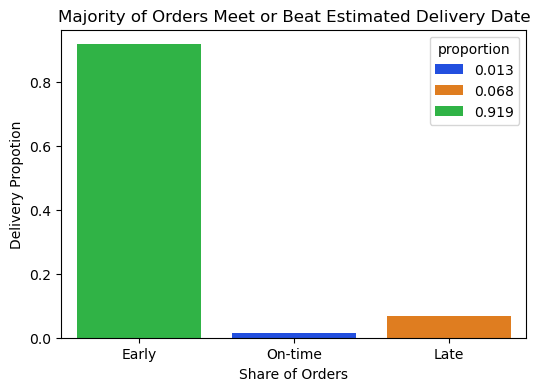

In [35]:
plt.figure(figsize=(6, 4))
sns.barplot(
    x=sla_summary.index,
    y=sla_summary,
    hue=sla_summary.round(3),
    palette='bright'
)
plt.title("Majority of Orders Meet or Beat Estimated Delivery Date")
plt.xlabel("Share of Orders")
plt.ylabel("Delivery Propotion")
plt.show()

**Interpretation**

Most orders meet or exceed estimated delivery dates, indicating generally strong SLA performance. However, the minority of late deliveries have a disproportionate negative impact on customer satisfaction.

---

* **Plot:** Histogram of `actual_wait_time`
* **Goal:**

  * Understand typical end-to-end delivery duration
  * Identify extreme outliers (e.g., unusually long deliveries)
* **Expectation:**
  Most deliveries should cluster within a reasonable time window, with a long right tail representing operational failures or edge cases.

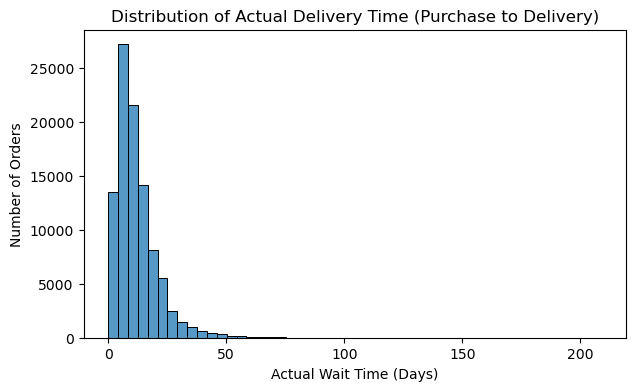

In [36]:
plt.figure(figsize=(7, 4))
sns.histplot(
    orders_enriched["actual_wait_time"],
    bins=50,
    kde=False
)
plt.title("Distribution of Actual Delivery Time (Purchase to Delivery)")
plt.xlabel("Actual Wait Time (Days)")
plt.ylabel("Number of Orders")
plt.show()

**Interpretation**

The distribution of actual wait time is left-skewed, with most orders delivered within a consistent time window and a small tail of extreme delays. These outliers likely reflect operational or last-mile failures rather than typical logistics performance.

---

* **Plot:** Histogram of `delivery_delay`
* **Goal:**

  * Measure how often orders are early, on-time, or late
  * Inspect the distribution and tail behavior of delivery delays
* **Expectation:**
  A majority of orders should be on time or early, with a smaller but operationally meaningful tail of late deliveries.

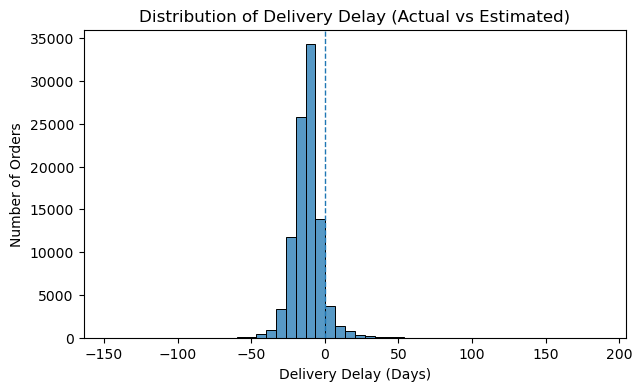

In [37]:
plt.figure(figsize=(7, 4))
sns.histplot(
    orders_enriched["delivery_delay"],
    bins=50,
    kde=False
)

plt.title("Distribution of Delivery Delay (Actual vs Estimated)")
plt.xlabel("Delivery Delay (Days)")
plt.ylabel("Number of Orders")
plt.axvline(0, linestyle="--", linewidth=1)
plt.show()

**Interpretation**

The delivery delay distribution is centered around zero, showing that most orders are delivered on time or early, with negative values reflecting conservative estimates or efficient execution. A smaller right tail captures late deliveries, which, despite their lower frequency, are operationally significant due to their outsized impact on customer satisfaction.

---

### 6.1.3 Order Volume by Geography

* **Plot:** Bar chart of number of orders by `customer_state`
* **Goal:**

  * Identify high-volume regions
  * Ensure later geographic comparisons are interpreted in the context of demand concentration
* **Expectation:**
  States with major urban centers are expected to dominate order volume.

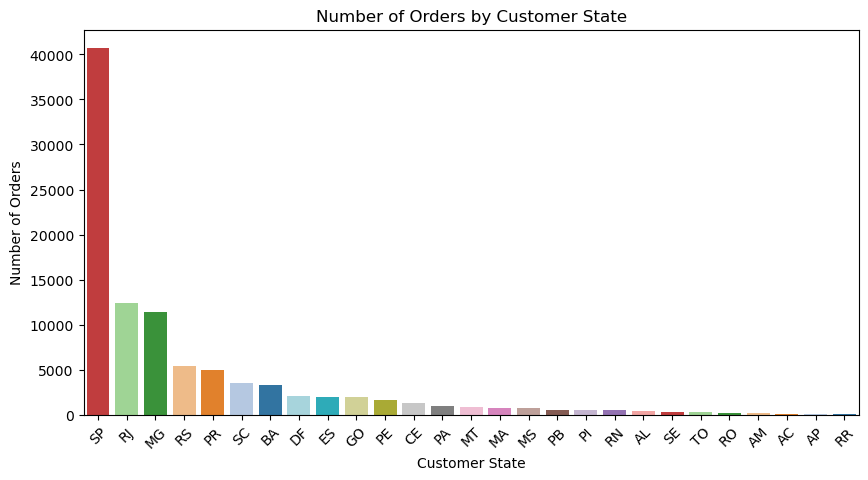

In [38]:
plt.figure(figsize=(10, 5))

orders_by_state = (
    orders_enriched["customer_state"]
    .value_counts()
)

sns.barplot(
    x=orders_by_state.index,
    y=orders_by_state.values,
    hue=orders_by_state.values,
    palette='tab20',
    legend=False
)

plt.title("Number of Orders by Customer State")
plt.xlabel("Customer State")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()

**Interpretation**

Order volume is heavily concentrated in a few states, with São Paulo (SP) dominating total orders,
followed by other major urban states such as RJ and MG. This concentration implies that logistics performance in these high-volume states has a disproportionate impact on overall customer experience.

## 6.2 Bivariate Analysis: Testing Key Hypotheses

This section directly evaluates the core analytical questions of the project by examining relationships between delivery performance, customer satisfaction, and operational factors.

### 6.2.1 Delivery Delay vs. Customer Satisfaction (Behavioral Analysis)


* **Feature Engineering:**
  Delivery delays are discretized into operationally meaningful categories `delay_range`, such as:

  * Early / On-time
  * 1–3 days late
  * 4–7 days late
  * 8+ days late

* **Plot:** Box plot of `review_score` grouped by `delay_range`

* **Goal:**

  * Test whether customer satisfaction degrades in a non-linear manner as delivery delays increase
  * Identify whether small delays are tolerated while larger delays incur a disproportionate penalty

* **Expectation:**
  Review scores are expected to remain relatively stable for minor delays, with a sharper decline beyond a specific delay threshold.

In [39]:
# Feature Engineering: Delay Buckets
orders_enriched["delay_range"] = pd.cut(
    orders_enriched["delivery_delay_capped"],
    bins=[-np.inf, 1, 4, 8, np.inf],
    right=False,
    labels=["On-time / Early", "1–3 Days Late", "4–7 Days Late", "8+ Days Late"]
)

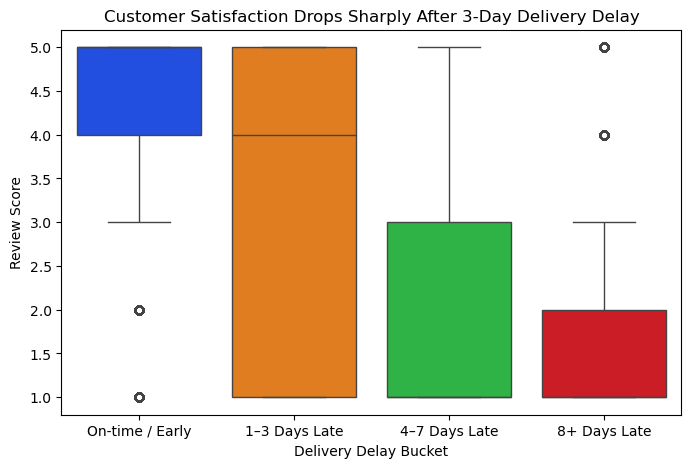

In [40]:
# Plot: Review Score by Delay Range
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=orders_enriched,
    x="delay_range",
    y="review_score",
    hue="delay_range",
    palette="bright",
)
plt.title("Customer Satisfaction Drops Sharply After 3-Day Delivery Delay")
plt.xlabel("Delivery Delay Bucket")
plt.ylabel("Review Score")
plt.show()

In [41]:
dist = (
    orders_enriched.groupby(['delay_range', 'review_score'], observed=False)
      .size()
      .unstack()
      .apply(lambda x: x / x.sum(), axis=1)
)

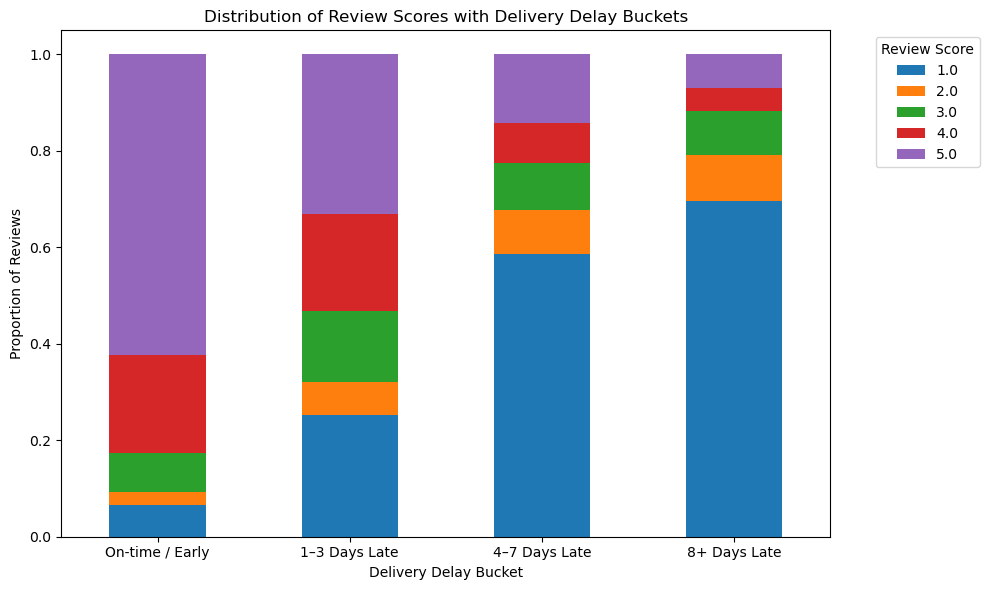

In [42]:
# Plot: Distribution of Review Score by Delay Range
dist.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    rot=0,
)

plt.title("Distribution of Review Scores with Delivery Delay Buckets")
plt.xlabel("Delivery Delay Bucket")
plt.ylabel("Proportion of Reviews")
plt.legend(title="Review Score", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

**Interpretation**

Customer satisfaction remains relatively stable for on-time deliveries and delays up to 3 days. Beyond this threshold, review scores drop sharply, indicating a behavioral tipping point where delays meaningfully damage customer perception.

---

### 6.2.2 Distance vs. Delivery Delay

* **Plot:** Scatter plot of seller–customer distance versus `delivery_delay`, including a regression line
* **Goal:**

  * Evaluate whether physical distance is a meaningful driver of delivery delays
  * Distinguish geographic constraints from operational inefficiencies
* **Expectation:**
  Distance may show a weak correlation with delivery delay, suggesting that geography alone does not fully explain late deliveries.

In [43]:
orders_enriched["distance_km"] = orders_enriched.apply(
    lambda x: geodesic((x["seller_lat"], x["seller_lng"]), (x["customer_lat"], x["customer_lng"])).km
                       if pd.isna(x[["seller_lat", "customer_lat"]]).sum()==0 else np.nan,
    axis=1
)

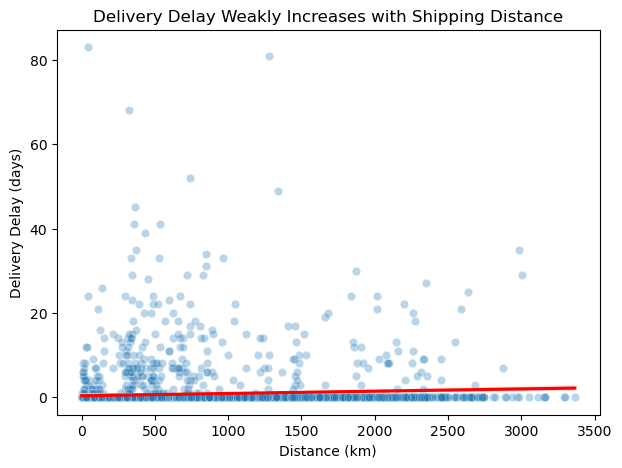

In [44]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=orders_enriched.sample(5000, random_state=0),
    x="distance_km",
    y="delivery_delay_capped",
    alpha=0.3
)
sns.regplot(
    data=orders_enriched.sample(5000, random_state=0),
    x="distance_km",
    y="delivery_delay_capped",
    scatter=False,
    color="red"
)
plt.title("Delivery Delay Weakly Increases with Shipping Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Delay (days)")
plt.show()

**Interpretation**

Distance shows only a weak correlation with delivery delay, suggesting that geography alone does not explain late deliveries. Operational factors likely play a larger role.

### 6.2.3 Geographic Delay Analysis (State-Level)

* **Plot:** Heatmap (choropleth) of Brazil showing average `delivery_delay_capped` by `customer_state`

* **Goal:**

  * Identify regional disparities in SLA violations
  * Highlight states with consistently higher delay severity

* **Expectation:**
  After capping early and on-time deliveries at zero, geographic differences in SLA violations are expected to become more pronounced, revealing regions with structurally higher logistics risk.

In [45]:
state_delay = (
    orders_enriched
    .groupby("customer_state", as_index=False)
    .agg(
        avg_delivery_delay=("delivery_delay_capped", "mean"),
        order_count=("order_id", "count")
    )
)

In [46]:
geo_delay = brazil_states.merge(
    state_delay,
    left_on="id",
    right_on="customer_state",
    how="left",
)

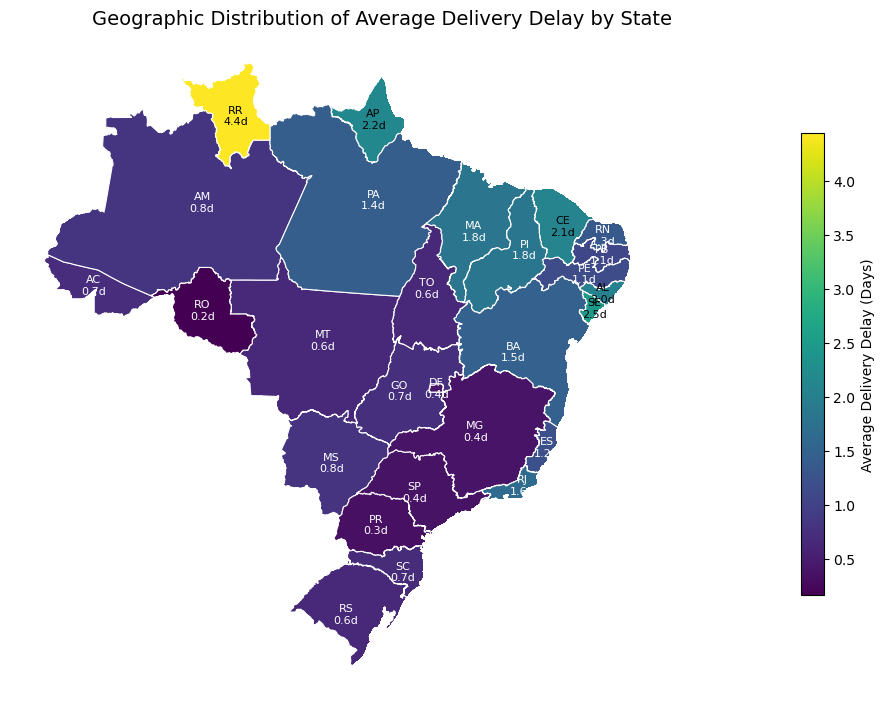

In [47]:
fig, ax = plt.subplots(figsize=(12, 10))

geo_delay.plot(
    column="avg_delivery_delay",
    cmap="viridis",
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    legend_kwds={
        "label": "Average Delivery Delay (Days)",
        "shrink": 0.6
    },
    ax=ax
)

# Annotate each state
for _, row in geo_delay.iterrows():
    centroid = row.geometry.representative_point()
    ax.text(
        centroid.x,
        centroid.y,
        f"{row['id']}\n{row['avg_delivery_delay']:.1f}d",
        ha="center",
        va="center",
        fontsize=8,
        color="black" if row["avg_delivery_delay"] > 2 else "white"
    ) 

ax.set_title(
    "Geographic Distribution of Average Delivery Delay by State",
    fontsize=14,
)

ax.axis("off")
plt.show()

**Interpretaion**

Northern and eastest states exhibiting higher average delays. This indicates structural or operational logistics risk and highlights regions where carrier or infrastructure interventions are most needed.

### 6.2.4 Delay Decomposition (Operational Analysis)

* **Approach:**
  Decompose delivery delays for late orders into seller-side and carrier-side components using operational deadline proxies:

  * **Seller delay:** excess time beyond `shipping_limit_date`
  * **Carrier delay:** excess time beyond the remaining estimated delivery window

* **Plot:** Bar chart comparing average seller delay vs. average carrier delay (late orders only)

* **Goal:**

  * Attribute excess delivery delay to upstream (seller handling) versus downstream (carrier transit) operations
  * Identify which component contributes most to missed delivery expectations

* **Expectation:**
  Carrier-side delays are expected to dominate excess delay, indicating that downstream logistics execution is the primary bottleneck rather than seller preparation.

In [48]:
# convert order_delivered_carrier_date to datetime
orders_enriched["order_delivered_carrier_date"] = pd.to_datetime(
    orders_enriched["order_delivered_carrier_date"]
)

In [49]:
# Seller Delay
orders_enriched["seller_delay_days"] = (
    orders_enriched["order_delivered_carrier_date"] -
    orders_enriched["latest_shipping_limit_date"]
).dt.days

orders_enriched["seller_delay_days"] = orders_enriched["seller_delay_days"].clip(lower=0)

In [50]:
# Carrier delay
orders_enriched["expected_carrier_time_days"] = (
    orders_enriched["order_estimated_delivery_date"] -
    orders_enriched["order_delivered_carrier_date"]
).dt.days

orders_enriched["actual_carrier_time_days"] = (
    orders_enriched["order_delivered_customer_date"] -
    orders_enriched["order_delivered_carrier_date"]
).dt.days

orders_enriched["carrier_delay_days"] = (
    orders_enriched["actual_carrier_time_days"] -
    orders_enriched["expected_carrier_time_days"]
).clip(lower=0)

In [51]:
# Consider late orders only
late_orders = orders_enriched[orders_enriched["delivery_delay"] > 0]

sla_decomposition = late_orders[
    ["seller_delay_days", "carrier_delay_days"]
].mean()

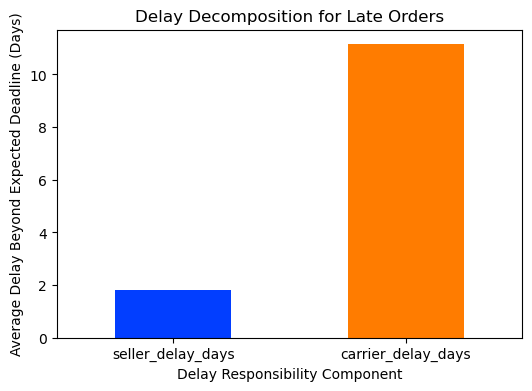

In [52]:
# Plot delay components
sla_decomposition.plot(
    kind="bar",
    figsize=(6, 4),
    color=sns.color_palette("bright", 2),
    rot=0
)

plt.title("Delay Decomposition for Late Orders")
plt.ylabel("Average Delay Beyond Expected Deadline (Days)")
plt.xlabel("Delay Responsibility Component")
plt.show()

**Interpretation**

Carrier transit is the primary driver of late deliveries. For delayed orders, carrier-related delays average approximately 11 days beyond the expected delivery date, compared to about 2 days attributable to seller shipping delays. This suggests that most delivery failures originate downstream in carrier transit and last-mile operations rather than at seller fulfillment.

## 6.3 Multivariate Analysis: Risk-Impact Analysis

This section evaluates how multiple operational and logistical factors jointly influence delivery delays and customer satisfaction, capturing interactions that are not visible in bivariate analysis alone.

#### 6.3.1 Geographic SLA Risk & Impact

* **Plot:** Bubble scatter plot with:

  * **X-axis:** Number of orders per state (exposure)
  * **Y-axis:** Average `delivery_delay_capped` (severity)
  * **Bubble size:** Number of late orders (absolute impact)
  * **Color:** Late delivery rate (%) (frequency)

* **Goal:**

  * Prioritize states where delivery delays affect the largest number of customers
  * Distinguish high-impact regions from localized logistics issues

* **Expectation:**
  States with both high order volume and elevated capped delivery delays are expected to emerge as top operational priorities, while states with high delays but low volume are anticipated to reflect localized inefficiencies with limited platform-wide impact.

In [53]:
state_metrics = (
    orders_enriched
    .groupby("customer_state")
    .agg(
        order_count=("order_id", "nunique"),
        avg_delay_capped=("delivery_delay_capped", "mean"),
        late_orders=("delivery_delay_capped", lambda x: (x > 0).sum())
    )
    .reset_index()
)

In [54]:
# compute late rate percentage
state_metrics["late_rate_pct"] = (
    state_metrics["late_orders"] / state_metrics["order_count"] * 100
)

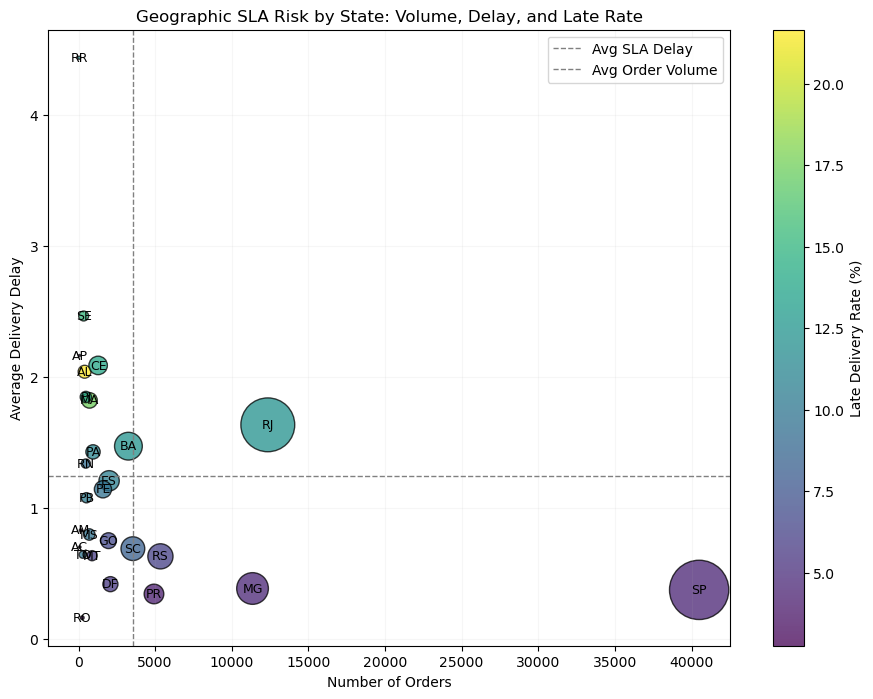

In [55]:
plt.figure(figsize=(11, 8))

scatter = plt.scatter(
    state_metrics["order_count"],
    state_metrics["avg_delay_capped"],
    s=state_metrics["late_orders"],   # bubble size = impact
    c=state_metrics["late_rate_pct"],       # color = frequency
    cmap="viridis",
    alpha=0.75,
    edgecolor="black"
)

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Late Delivery Rate (%)")

# Annotate states
for _, row in state_metrics.iterrows():
    plt.text(
        row["order_count"],
        row["avg_delay_capped"],
        row["customer_state"],
        fontsize=9,
        ha="center",
        va="center"
    )

# Reference lines
plt.axhline(
    state_metrics["avg_delay_capped"].mean(),
    linestyle="--",
    color="gray",
    linewidth=1,
    label="Avg SLA Delay"
)

plt.axvline(
    state_metrics["order_count"].mean(),
    linestyle="--",
    color="gray",
    linewidth=1,
    label="Avg Order Volume"
)

plt.title("Geographic SLA Risk by State: Volume, Delay, and Late Rate")
plt.xlabel("Number of Orders")
plt.ylabel("Average Delivery Delay")
plt.legend()
plt.grid(alpha=0.1)

plt.show()


**Interpretation**

The plot shows that Rio de Janeiro (RJ) combines both high order volume and elevated delivery delays, making it a critical risk area due to the large number of affected customers.
In contrast, several states exhibit high average delivery delays despite low order volumes, indicating localized logistics issues with limited overall business impact.

## Step 7: Findings & Summary

This analysis examined the relationship between delivery performance and customer satisfaction in Olist’s marketplace, with a focus on identifying the primary drivers of late deliveries, their geographic distribution, and their operational impact at scale.

### 7.1 Key Findings

1. **Customer tolerance for delivery delays is non-linear**
   Customer satisfaction remains relatively stable for on-time deliveries and small delays (up to approximately 3 days). Beyond this threshold, review scores decline sharply, indicating a behavioral tipping point rather than a linear penalty for lateness.

2. **Shipping distance is a weak standalone predictor of delivery delay**
   Although longer seller–customer distances are associated with slightly higher delays on average, substantial variability exists across all distance ranges. Meaningful delays are observed even for short-distance shipments, suggesting that operational execution and logistics processes dominate over geographic distance alone.

3. **Carrier transit time is the dominant source of excess delivery delay**
   SLA-based delay decomposition shows that, for late orders, carrier-side transit contributes the majority of excess delay (approximately 11 days on average), while seller handling time contributes a smaller share (approximately 2 days). This indicates that most missed delivery expectations occur after the order leaves the seller.

4. **Geographic SLA risk varies significantly and is not explained by early deliveries**
   When delivery delays are capped to isolate SLA violations, geographic disparities in logistics performance become more pronounced. Several states exhibit consistently higher average delays, reflecting structural or operational logistics risk rather than effects driven by early or on-time deliveries.

5. **High-volume regions amplify the business impact of delivery delays**
   A volume-aware geographic analysis reveals that some high-order-volume states—most notably RJ—combine elevated delivery delays with large customer exposure, making them critical operational risk areas. In contrast, some low-volume states exhibit high delays that indicate localized logistics issues with limited platform-wide impact.

---

### 7.2 Business Implications

* Preventing delivery delays beyond the 3-day tolerance threshold is likely to yield disproportionately large improvements in customer satisfaction.
* Isolated seller-side interventions are unlikely to materially reduce late deliveries without parallel improvements in carrier and last-mile performance.
* The highest return on logistics optimization efforts lies in improving carrier performance and SLA enforcement in high-volume regions, while targeted interventions may be required to address persistent regional inefficiencies.

---

### 7.3 Summary

Overall, the analysis shows that delivery performance in Olist’s marketplace is driven primarily by downstream logistics execution rather than seller preparation or shipping distance alone. By combining SLA-based delay attribution, behavioral thresholds, and volume-aware geographic analysis, the findings provide a clear and actionable foundation for prioritizing logistics interventions that maximize customer impact and operational efficiency.


## Step 8: Limitations & Next Steps

While the analysis provides actionable insights into delivery performance and customer satisfaction, it is important to acknowledge the limitations of the data and methodology and outline potential directions for further investigation.

---

### 8.1 Limitations & Risks

* **Platform-Specific Data Bias**
  The dataset includes only orders placed through the Olist marketplace. As such, the findings may not fully generalize to the broader Brazilian e-commerce ecosystem, which may involve different seller profiles, logistics partners, or fulfillment models.

* **Simplified Distance Measurement**
  Seller–customer distance was calculated using straight-line (Euclidean) distance based on geographic coordinates. This does not reflect real-world transportation routes, traffic conditions, or infrastructure constraints, which may weaken the observed relationship between distance and delivery delay.

* **Causality vs. Correlation**
  The analysis identifies a strong association between delivery delays and lower review scores, but it does not establish causality. Customer dissatisfaction may also be driven by unobserved factors such as product defects, incorrect items, or customer service issues that coincide with late deliveries.

* **Unobserved Operational Factors**
  The dataset does not include information on carrier identity, shipment mode, warehouse capacity, or external disruptions (e.g., weather events, strikes, holidays). These unobserved variables may partially explain observed delays and regional performance differences.

---

### 8.2 Next Steps

Given additional time, data, or resources, the following extensions would meaningfully deepen the analysis:

* **Predictive Risk Modeling**
  Develop a classification model to flag high-risk orders at purchase time based on features such as seller location, customer location, product attributes, and historical delay patterns. This could enable proactive interventions before SLA violations occur.

* **Carrier-Level Performance Analysis**
  Incorporate carrier identifiers (if available) to directly compare transit performance across logistics partners and quantify their contribution to SLA failures.

* **Augmented External Data**
  Enrich the dataset with external signals such as weather data, national and regional holiday calendars, or public infrastructure indicators to better explain temporal and geographic delay patterns.

* **Causal Analysis of Customer Satisfaction**
  Apply causal inference techniques or controlled comparisons to disentangle the impact of delivery delays from other drivers of negative reviews, such as product quality or seller reliability.

---

These extensions would allow the analysis to move from descriptive and diagnostic insights toward predictive and prescriptive decision support, further strengthening its value for logistics strategy and operational planning.
